In [110]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib_inline.backend_inline
import seaborn as sns
import matplotlib as mpl
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer

# Data cleaning and Engineering

In [111]:

def fill_na(df,columns=[], method='mean'):
    """
    Fill missing values in a DataFrame without replacing the original data.
    
    Parameters:
    - df: pd.DataFrame, the original DataFrame
    - method: str, the method to use for filling missing values ('mean', 'median', 'mode', 'ffill', 'bfill')
    
    Returns:
    - pd.DataFrame, a new DataFrame with missing values filled
    """
    df_filled = df.copy()
    
    if not columns:
        columns = df_filled.columns
    if method == 'mean':
        fill_values = {col: df_filled[col].mean() for col in columns if df_filled[col].dtype in ['float64', 'int64']}
        print(fill_values)
        df_filled.fillna(value=fill_values, inplace=True)
    
    elif method == 'median':
        fill_values = {col: df_filled[col].median() for col in columns if df_filled[col].dtype in ['float64', 'int64']}
        print(fill_values)
        df_filled.fillna(value=fill_values, inplace=True)
    
    elif method == 'mode':
        fill_values = {col: df_filled[col].mode()[0] for col in columns}
        print(fill_values)

        df_filled[columns].fillna(value=fill_values, inplace=True)
    
    elif method == 'ffill' or method == 'bfill':
        df_filled[columns].fillna(method=method, inplace=True)
    
    else:
        raise ValueError("Invalid method. Choose from 'mean', 'median', 'mode', 'ffill', 'bfill'.")
    
    return df_filled

Transform numerical values to acquire a smoother distribution

In [112]:

# Define the transform function
def transform(series):
    max_val = series.max()
    left_log_col = np.log(max_val + 1) - np.log(series)
    left_squared_log_col = np.sqrt(left_log_col)
    return left_squared_log_col


In [113]:
def features_transform(df: pd.DataFrame) -> pd.DataFrame:
    
    numerical_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalCost']
    object2int_columns = ['Num', 'Group', 'Person']
    categorical_feat = ['HomePlanet','CryoSleep','Destination','VIP','Name','Side','Deck']

    # Cabin split
    df[['Deck', 'Num', 'Side']] = df.pop('Cabin').str.split('/', expand=True)
    df[['Group', 'Person']] = df['PassengerId'].str.split('_', expand=True)

    imp= KNNImputer(n_neighbors=5) 

    df1_imp = imp.fit_transform(df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Num', 'Person']])
    df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Num', 'Person']] = df1_imp

    df[categorical_feat] = fill_na(df[categorical_feat],method='mode')

    for col in object2int_columns:
        df[col] = df[col].astype(int)

    # Total cost feature
    df['TotalCost'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']

    # Log squared transform
    #for column in numerical_columns:
    #    df[column] = np.where(df[column] != 0, transform(df[column]), df[column])
#    for feature in df.columns:
#       print(f"{feature} has {df[feature].isnull().sum()}")
    
    return df

le = LabelEncoder()

def feature_encode(df: pd.DataFrame) -> pd.DataFrame:
    # List of features to encode
    feats2hotencode = ['HomePlanet', 'Destination', 'Deck']
    # Perform one-hot encoding
    df = pd.get_dummies(df, columns=feats2hotencode)
    feats2encode = ['CryoSleep','VIP','Side']
    for feat in feats2encode:
        df[feat] = le.fit_transform(df[feat])
    return df


# Data preparation for model
- Imputing NA values
- Expand features
- Transform numerical features
- Split train/validation data
- Scaling

In [114]:
train_set = pd.read_csv('data/train.csv')
test_set = pd.read_csv('data/test.csv')
LABELS_SUB = test_set['PassengerId']

test_set = features_transform(test_set)
test_set = feature_encode(test_set)

train_set = features_transform(train_set)
train_set = feature_encode(train_set)

print(train_set.shape,test_set.shape)

Y = train_set['Transported'].to_numpy()
x_labels = list(train_set.columns)
x_labels.remove('Transported')
x_labels.remove('Name')
x_labels.remove('PassengerId')
print(x_labels)

X_test = test_set[x_labels].astype(float).to_numpy()
X = train_set[x_labels].astype(float).to_numpy()

for i in range(len(x_labels)):
    print(x_labels[i],': ',X[:,i])


{'HomePlanet': 'Earth', 'CryoSleep': False, 'Destination': 'TRAPPIST-1e', 'VIP': False, 'Name': 'Berta Barnolderg', 'Side': 'S', 'Deck': 'F'}


C:\Users\artur\AppData\Local\Temp\ipykernel_9980\1168067818.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filled[columns].fillna(value=fill_values, inplace=True)


{'HomePlanet': 'Earth', 'CryoSleep': False, 'Destination': 'TRAPPIST-1e', 'VIP': False, 'Name': 'Alraium Disivering', 'Side': 'S', 'Deck': 'F'}
(8693, 30) (4277, 29)
['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Num', 'Side', 'Group', 'Person', 'TotalCost', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T']
CryoSleep :  [0. 0. 0. ... 0. 0. 0.]
Age :  [39. 24. 58. ... 26. 32. 44.]
VIP :  [0. 0. 1. ... 0. 0. 0.]
RoomService :  [  0. 109.  43. ...   0.   0. 126.]
FoodCourt :  [   0.    9. 3576. ...    0. 1049. 4688.]
ShoppingMall :  [   0.   25.    0. ... 1872.    0.    0.]
Spa :  [0.000e+00 5.490e+02 6.715e+03 ... 1.000e+00 3.530e+02 0.000e+00]
VRDeck :  [   0.   44.   49. ...    0. 3235.   12.]
Num :  [   0.    0.    0. ... 1500.  608.  608.]
Side :  [0. 1. 1. ... 1. 1. 1.]


C:\Users\artur\AppData\Local\Temp\ipykernel_9980\1168067818.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filled[columns].fillna(value=fill_values, inplace=True)


# Organize train/test data

In [115]:
all_data_train = True

x_train, x_cv, y_train, y_cv = train_test_split(X,Y,test_size=0.3)
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train).unsqueeze(1)
x_cv = torch.Tensor(x_cv)
y_cv = torch.Tensor(y_cv).unsqueeze(1)

if all_data_train:
    x_train = torch.Tensor(X)
    y_train = torch.Tensor(Y).unsqueeze(1)

# Scaling

In [116]:
scaler = StandardScaler().fit(x_train)
x_train = torch.Tensor(scaler.transform(x_train))
x_cv = torch.Tensor(scaler.transform(x_cv))

for i in range(len(x_labels)):
    print(x_labels[i],': ',x_train[:,i])

CryoSleep :  tensor([-0.7417, -0.7417, -0.7417,  ..., -0.7417, -0.7417, -0.7417])
Age :  tensor([ 0.7097, -0.3334,  2.0309,  ..., -0.1943,  0.2229,  1.0574])
VIP :  tensor([-0.2085, -0.2085,  2.7869,  ..., -0.2085, -0.2085, -0.2085])
RoomService :  tensor([-0.3383, -0.1735, -0.2733,  ..., -0.3383, -0.3383, -0.1478])
FoodCourt :  tensor([-0.2835, -0.2779,  1.9545,  ..., -0.2835,  0.3730,  2.6504])
ShoppingMall :  tensor([-0.2878, -0.2461, -0.2878,  ...,  2.8388, -0.2878, -0.2878])
Spa :  tensor([-0.2739,  0.2135,  5.6878,  ..., -0.2730,  0.0395, -0.2739])
VRDeck :  tensor([-0.2662, -0.2274, -0.2230,  ..., -0.2662,  2.5832, -0.2556])
Num :  tensor([-1.1849, -1.1849, -1.1849,  ...,  1.7730,  0.0140,  0.0140])
Side :  tensor([-0.9937,  0.8497,  0.8497,  ...,  0.8497,  0.8497,  0.8497])
Group :  tensor([-1.7344, -1.7340, -1.7337,  ...,  1.7394,  1.7397,  1.7397])
Person :  tensor([-0.4912, -0.4912, -0.4912,  ..., -0.4912, -0.4912,  0.4574])
TotalCost :  tensor([-0.5192, -0.2574,  3.1737,  .

# ANN construction

In [117]:
class transportedProb(nn.Module):
    def __init__(self):
        '''Populate with the layers of the model'''
        super(transportedProb,self).__init__()

        # define layers
        self.input = nn.Linear(in_features=27,out_features=40)
        self.hidden1 = nn.Linear(40,80)
        self.hidden2 = nn.Linear(80,60)
        
        self.hidden3 = nn.Linear(60,40)
        self.hidden4 = nn.Linear(40,20)
        self.hidden5 = nn.Linear(20,10)
        self.output = nn.Linear(10,1)


    def forward(self,x):
        '''Operations that are taking place in the layers'''

        # input
        x = F.relu(self.input(x))
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.hidden4(x))
        x = F.relu(self.hidden5(x))
        # output
        x = F.sigmoid(self.output(x))

        return x

In [118]:
def create_model(lr,lossfun):
    model = transportedProb()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    lossfun = torch.nn.MSELoss()  
    return model, lossfun, optimizer

# Train function

In [119]:
def train(model, lossfun, optimizer, inputs, targets, epochs=100):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    inputs, targets = inputs.to(device), targets.to(device)
    
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lossfun(outputs, targets)
        loss.backward()
        optimizer.step()
        losses[epoch] = loss.item()

        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs} - Loss: {loss.item()}')
    return losses

# Training

In [131]:
epochs = 10000
lr = 0.001


model = transportedProb()
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
model.train()
losses = train(model, nn.MSELoss(), optimizer, x_train, y_train,epochs=epochs)
    
model.eval()
with torch.no_grad():
    outputs = model(x_cv)
    loss_cv = nn.MSELoss()(outputs, y_cv)
    
    # Apply threshold to get binary predictions
    predictions = (outputs >= 0.5).float()

    # Calculate accuracy
    correct = (predictions == y_cv).float().sum()
    accuracy = correct / y_cv.shape[0]
    
print("cv loss: ",loss_cv.item())
# print("train losses: ", losses)
# 0.0539


Epoch 0/10000 - Loss: 0.2512931227684021
Epoch 10/10000 - Loss: 0.2024744302034378
Epoch 20/10000 - Loss: 0.17500406503677368
Epoch 30/10000 - Loss: 0.14534026384353638
Epoch 40/10000 - Loss: 0.13500899076461792
Epoch 50/10000 - Loss: 0.12889577448368073
Epoch 60/10000 - Loss: 0.12479117512702942
Epoch 70/10000 - Loss: 0.12139128148555756
Epoch 80/10000 - Loss: 0.11672608554363251
Epoch 90/10000 - Loss: 0.11531665176153183
Epoch 100/10000 - Loss: 0.11031264811754227
Epoch 110/10000 - Loss: 0.1096028983592987
Epoch 120/10000 - Loss: 0.10688142478466034
Epoch 130/10000 - Loss: 0.10388204455375671
Epoch 140/10000 - Loss: 0.10345111787319183
Epoch 150/10000 - Loss: 0.10258299112319946
Epoch 160/10000 - Loss: 0.09779897332191467
Epoch 170/10000 - Loss: 0.09705600142478943
Epoch 180/10000 - Loss: 0.0961402952671051
Epoch 190/10000 - Loss: 0.09782154113054276
Epoch 200/10000 - Loss: 0.09460288286209106
Epoch 210/10000 - Loss: 0.09179132431745529
Epoch 220/10000 - Loss: 0.0914468765258789
Epoc

# Evaluation

In [132]:
print("Accuracy on validation: ",accuracy)
#.9367

Accuracy on validation:  tensor(0.9666)


(Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'))

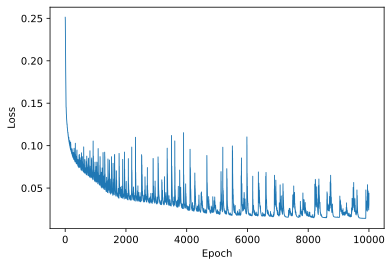

In [133]:
# show the losses
fig,ax = plt.subplots(figsize=(6,4))
ax.plot(range(1,epochs+1),losses,'-',markerfacecolor='w',linewidth=.9,label=f"{np.round(lr,3)}")
ax.set_xlabel('Epoch'), ax.set_ylabel('Loss')

# Making submission

In [134]:
x_test = torch.Tensor(scaler.transform(X_test))
outputs = model(torch.Tensor(x_test))
# Apply threshold to get binary predictions
predictions = (outputs >= 0.5).float()
predictions = pd.DataFrame(predictions.detach(),columns=['Transported'])
print(predictions.describe())
predictions

       Transported
count  4277.000000
mean      0.512743
std       0.499896
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000


,Transported
0,1.0
1,0.0
2,1.0
3,1.0
4,1.0
...,...
4272,0.0
4273,1.0
4274,1.0
4275,1.0


In [135]:
predictions['PassengerId'] = LABELS_SUB
predictions['Transported'] = predictions['Transported'].astype(bool)
predictions = predictions[['PassengerId','Transported']]

In [136]:
predictions.to_csv('./data/submissionANN.csv',index=False)